In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

In [89]:
from ipypublish import nb_setup
# https://stackoverflow.com/a/39566040/11552622
rcparams = {
    'axes.titlesize':13,
    'axes.labelsize':9,
    'xtick.labelsize':8,
    'ytick.labelsize':8
}
plt = nb_setup.setup_matplotlib(rcparams=rcparams)

# Introduction

## Aim

Implement framework to extract data generated by the script `script_stats_dnn.py` and concatenate it. This aims to process data from a single dataset. Further (but easy) manipulation are required to merge everything together (e.g. `pandas.join`).


## Quick implementation overview

The script is runned from a folder containing `X.mat` and `Y.mat` files. It creates a new directory for each tested DNN configuration. For instance, the file hierarchy of the root folder once script is finished: 

```
.
├── 1_hlayers_16_neurons_40_aks
├── 1_hlayers_32_neurons_40_aks
├── 1_hlayers_64_neurons_40_aks
├── 1_hlayers_8_neurons_40_aks
├── 2_hlayers_16_neurons_40_aks
├── 2_hlayers_32_neurons_40_aks
├── 2_hlayers_64_neurons_40_aks
├── 2_hlayers_8_neurons_40_aks
├── 4_hlayers_16_neurons_40_aks
├── 4_hlayers_32_neurons_40_aks
├── 4_hlayers_64_neurons_40_aks
├── 4_hlayers_8_neurons_40_aks
├── 6_hlayers_16_neurons_40_aks
├── 6_hlayers_32_neurons_40_aks
├── 6_hlayers_64_neurons_40_aks
├── 6_hlayers_8_neurons_40_aks
├── X.mat
└── Y.mat
```

Each folder has the structure:

```
1_hlayers_16_neurons_40_aks/
├── coefmaxs.npy
├── coefmins.npy
├── DNN_0D_Model.h5
├── DNN_Performance.eps
├── history.bin
├── log.txt
├── Losses.eps
├── parammaxs.npy
├── parammins.npy
├── Ytestpred.txt
└── Ytest.txt
```

We're interested in the files:

* `history.bin`: a pickled dictionnary containing the keras model's history (losses)
* 

## Setup

In [2]:
path = '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse'

# Walking around file hierarchy

## Aim

Given root folder, obtain the list of all files to load

## Let's go


In [10]:
def get_list(rootdir, fileformat):
    """
    :param fileformat: example: `.txt`
    """
    ls = []
    for dirname, subdirlist, filelist in os.walk(rootdir):
        for file in filelist:
            if file.endswith(fileformat):
                ls.append(os.path.join(dirname, file))
    
    return ls

In [15]:
get_list(path, '.bin')

['/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_16_neurons_40_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_32_neurons_40_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_64_neurons_40_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/1_hlayers_8_neurons_40_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/2_hlayers_16_neurons_40_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/2_hlayers_32_neurons_40_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/2_hlayers_64_neurons_40_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/2_hlayers_8_neurons_40_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/4_hlayers_16_neurons_40_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/4_hlayers_32_neurons_40_aks/history.bin',
 '/media/maousi/Data/tmp/dnn_stats/4000RPM_Pulse/4_hlayers_64_neurons_40_aks/history.bin',
 

In [17]:
ls = get_list(path, '.bin')

# Load, extract, create DataFrame

## Aim

Given the list of history files, load them, extract the losses, generate DataFrame.

## Routine: parse dnn config from file path



In [25]:
def parse_config(filepath):
    parent_dir = os.path.basename(os.path.dirname(filepath))
    ls = parent_dir.split('_')
    res = {
        'hlayers': 0,
        'neurons': 2,
        'aks': 4
    }
    return {key: int(ls[index]) for key, index in res.items()}

In [26]:
parse_config(ls[0]), parse_config(ls[1])

({'hlayers': 1, 'neurons': 16, 'aks': 40},
 {'hlayers': 1, 'neurons': 32, 'aks': 40})

## Routine : Extract losses

In [31]:
with open(ls[0], 'rb') as f:
    data = pickle.load(f)
data.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

(0.022715420554343023, 0.021871805665524383)

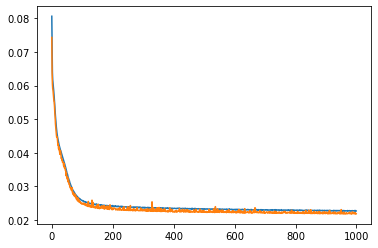

In [40]:
plt.plot(data['loss'])
plt.plot(data['val_loss'])
data['loss'][-1], data['val_loss'][-1]

In [39]:
def load_losses(filepath):
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    # We extract the last item of every list
    return {key: lst[-1] for key, lst in data.items()}

In [41]:
load_losses(ls[0])

{'loss': 0.022715420554343023,
 'mae': 0.094022974,
 'val_loss': 0.021871805665524383,
 'val_mae': 0.09184385}

## Wrapper

In [53]:
def process_stats_data(rootdir):
    files = get_list(rootdir, 'history.bin')
    data = []
    for f in files:
        info = parse_config(f)
        info.update(load_losses(f))
        data.append(info)
    return pd.DataFrame(data).sort_values(['hlayers', 'neurons', 'aks'])

In [54]:
df = process_stats_data(path)
df

,hlayers,neurons,aks,loss,mae,val_loss,val_mae
3,1,8,40,0.023084,0.095741,0.022269,0.094381
0,1,16,40,0.022715,0.094023,0.021872,0.091844
1,1,32,40,0.015843,0.081250,0.017787,0.087302
2,1,64,40,0.010569,0.064735,0.014129,0.073951
7,2,8,40,0.055028,0.188734,0.052676,0.184606
4,2,16,40,0.021522,0.091089,0.020850,0.088455
5,2,32,40,0.007790,0.058473,0.009364,0.067603
6,2,64,40,0.006523,0.053136,0.007222,0.055435
11,4,8,40,0.018045,0.087352,0.018927,0.093941
8,4,16,40,0.014180,0.075244,0.015003,0.077183


In [108]:
df.sort_values(['val_loss']).head()

,hlayers,neurons,aks,loss,mae,val_loss,val_mae
6,2,64,40,0.006523,0.053136,0.007222,0.055435
5,2,32,40,0.007790,0.058473,0.009364,0.067603
9,4,32,40,0.008635,0.059673,0.009943,0.062687
12,6,16,40,0.013157,0.072972,0.012584,0.069927
10,4,64,40,0.006488,0.051275,0.013493,0.070423


# Plot - Investigate loss <-> architecture

## Aim 

Visualize losses in function of number of layers, number of neurons.

In [94]:
sns.set(style='whitegrid')

In [104]:
def plot_dnn_stats(df):
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    
    ls_hlayers = df['hlayers'].value_counts('hlayers').index.values
    for hlayers in ls_hlayers:
        sub = df[df.hlayers == hlayers]
        ax[0].plot(sub.neurons, sub.val_loss, '-o', label=str(hlayers))
        ax[1].plot(sub.neurons, sub.val_mae, '-o')
    
    ax[0].legend(title='Nb layers')
    ax[0].set_xlabel('Number of neurons')
    ax[0].set_ylabel('Validation loss')
    ax[1].set_xlabel('Number of neurons')
    ax[1].set_ylabel('Mean absolute error')
    plt.subplots_adjust(wspace=.4)
    plt.tight_layout()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


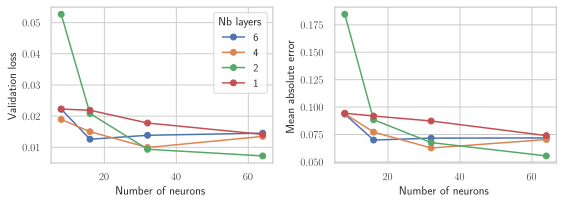

In [105]:
plot_dnn_stats(df)
plt.savefig('figs/dnn_architecture_stats.eps')

# General wrapper

In [101]:
def perform_dnn_architecture_analysis(basefolder, subfolders, suffixes):
    for folder, suffix_name in zip(subfolders, suffixes):
        folderpath = os.path.join(basefolder, folder)
        print(folder)
        
        df = process_stats_data(folderpath)
        plot_dnn_stats(df)
        plt.savefig(f'figs/dnn_architecture_stats_{suffix_name}.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


4000RPM_Pulse


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


5000RPM_Pulse


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


6000RPM_Pulse


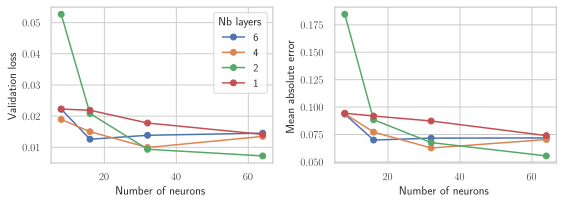

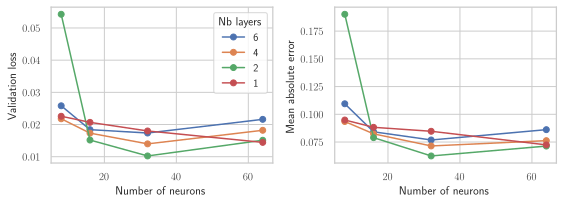

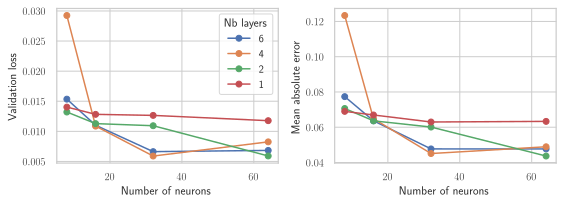

In [106]:
perform_dnn_architecture_analysis('/media/maousi/Data/tmp/dnn_stats', 
                                 ['4000RPM_Pulse', '5000RPM_Pulse', '6000RPM_Pulse'],
                                 ['4000RPM_AP', '5000RPM_AP', '6000RPM_AP'])